<a href="https://colab.research.google.com/github/VenkataraoGaddam/CourseWork/blob/main/TSR_GTSRB_CNN_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras import layers, models, applications
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.applications import ResNet50

import os

from google.colab import drive # Import the drive library

# Mount Google Drive
drive.mount('/content/drive') # Mount to access files
# Define the path to the GTSRB dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Train'
#dataset_path = '/content/GTSRB/Train'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.17.0
3.4.1
Mounted at /content/drive
Num GPUs Available:  0


In [2]:
data = []
labels = []
classes = 43

for i in range(classes):
  path = os. path.join(dataset_path, str(i))
  images = os.listdir(path)
  for a in images:
    try:
        image = Image.open(path + '/' + a) # Changed '\' to '/' for path separator
        image = image.resize((32,32))
        image = np.array(image)
        data.append(image)
        labels.append(i)
    except Exception as e: # Added Exception handling and print error message
        print(f"Error loading image: {a}, Error: {e}")
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)
# Preprocessing data - Normilizing and resize
data = data / 255.0
#labels = labels / 255.0

#Splitting training and testing dataset
X_t1, X_t2, y_t1, y_t2 = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_t1.shape, X_t2.shape, y_t1.shape, y_t2.shape)

#Converting labels into one hot encoding
num_classes = len(np.unique(y_t1))
y_t1 = to_categorical(y_t1, num_classes)
y_t2 = to_categorical(y_t2, num_classes)
print(num_classes)

(39209, 32, 32, 3) (39209,)
(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)
43


In [3]:
# Data Augmentation Layer Integration into Training Process

# Data Augmentation with adding random flips and rotations
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Apply data augmentation to the training dataset only
augmented_images = []
for image in X_t1:
  augmented_images.append(data_augmentation(image, training=True))


In [23]:
# Transfer Learning with ResNet50
# Load ResNet50 with pre-trained weights and without the top layers
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=X_t1.shape[1:])

# Build a transfer learning model
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
tl_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# Freeze the layers of ResNet50
for layer in resnet_model.layers:
    layer.trainable = False
# Fine tuning the model
for layer in resnet_model.layers[-50:]:   #Unfreeze last 50 layers
    layer.trainable = True

# Build a transfer learning model
#tl_model = Sequential()
#tl_model.add(resnet_model)
#tl_model.add(Flatten())
#tl_model.add(Dense(1024, activation='relu'))
#tl_model.add(Dropout(rate=0.5))
#tl_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#tl_model.summary()
#plot_model(tl_model, show_shapes=True, show_dtype=True)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2099s 4s/step - accuracy: 0.5895 - loss: 1.6283 - val_accuracy: 0.1560 - val_loss: 5.7476
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2078s 4s/step - accuracy: 0.9263 - loss: 0.3092 - val_accuracy: 0.9439 - val_loss: 0.1942
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2118s 4s/step - accuracy: 0.9702 - loss: 0.1223 - val_accuracy: 0.9746 - val_loss: 0.0897
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2066s 4s/step - accuracy: 0.9796 - loss: 0.0823 - val_accuracy: 0.9443 - val_loss: 0.1798
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2079s 4s/step - accuracy: 0.9681 - loss: 0.1439 - val_accuracy: 0.4702 - val_loss: 4.6046
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2080s 4s/step - accuracy: 0.9249 - loss: 0.3035 - val_accuracy: 0.9806 - val_loss: 0.0681
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2055s 4s/step - accuracy: 0.9660 - loss: 0.1532 - val_accuracy: 0.9760 - val_loss: 0.1005
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2045s 4s/step - accuracy: 0.9479 - loss: 0.2435 - 

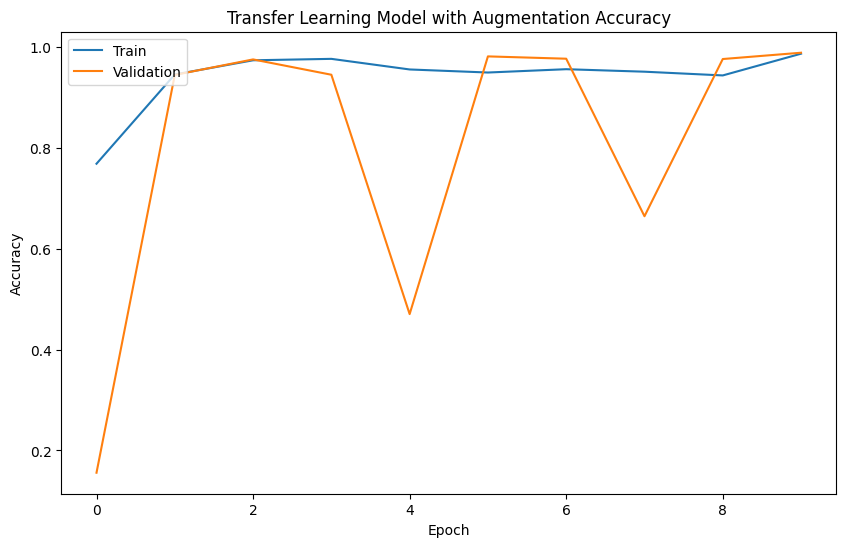

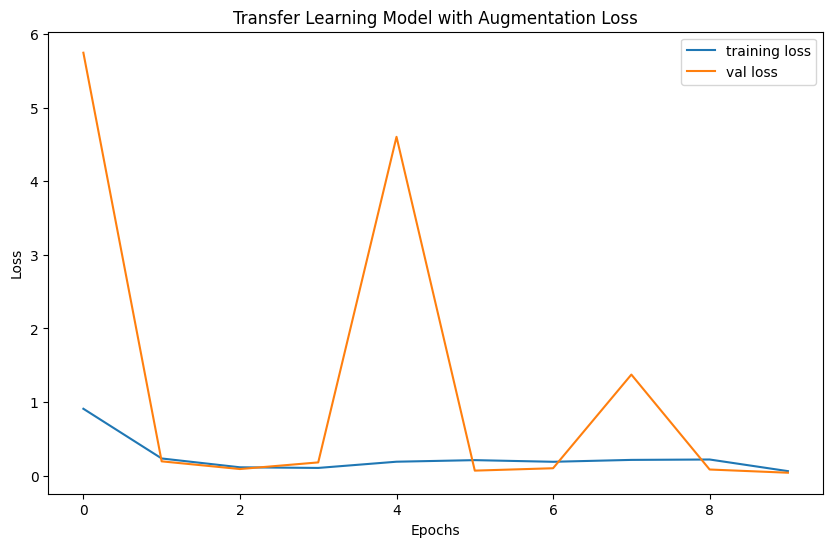

In [24]:
# Train the model with augmented data
history = tl_model.fit(X_t1, y_t1, batch_size=64, epochs=10, validation_data=(X_t2, y_t2))

# Plot training & validation accuracy values for transfer learning
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Transfer Learning Model with Augmentation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Transfer Learning Model with Augmentation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
tl_model.save('Transfer_Learning.keras')

In [25]:

#Building the CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_t1.shape[1:]))
cnn_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Dense(num_classes, activation='softmax')) #Compilation of the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()
# Plot the model
plot_model(cnn_model, show_shapes=True, show_dtype=True)
cnn_model.save('Building_CNN.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,939 (1.36 MB)

 Trainable params: 356,939 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Model Training and Validation
history = cnn_model.fit(X_t1, y_t1, batch_size=64, epochs=10, validation_data=(X_t2, y_t2))

cnn_model.save('CNN_Model.keras')

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 158s 315ms/step - accuracy: 0.3831 - loss: 2.2997 - val_accuracy: 0.9582 - val_loss: 0.1504
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 146s 297ms/step - accuracy: 0.9373 - loss: 0.2049 - val_accuracy: 0.9844 - val_loss: 0.0642
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 202s 297ms/step - accuracy: 0.9605 - loss: 0.1270 - val_accuracy: 0.9920 - val_loss: 0.0370
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 203s 298ms/step - accuracy: 0.9771 - loss: 0.0720 - val_accuracy: 0.9915 - val_loss: 0.0321
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 147s 300ms/step - accuracy: 0.9848 - loss: 0.0493 - val_accuracy: 0.9932 - val_loss: 0.0282
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 149s 303ms/step - accuracy: 0.9846 - loss: 0.0482 - val_accuracy: 0.9943 - val_loss: 0.0265
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 171s 348ms/step - accuracy: 0.9862 - loss: 0.0417 - val_accuracy: 0.9948 - val_loss: 0.0274
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 203s 350ms/step - accuracy: 0.9890 -

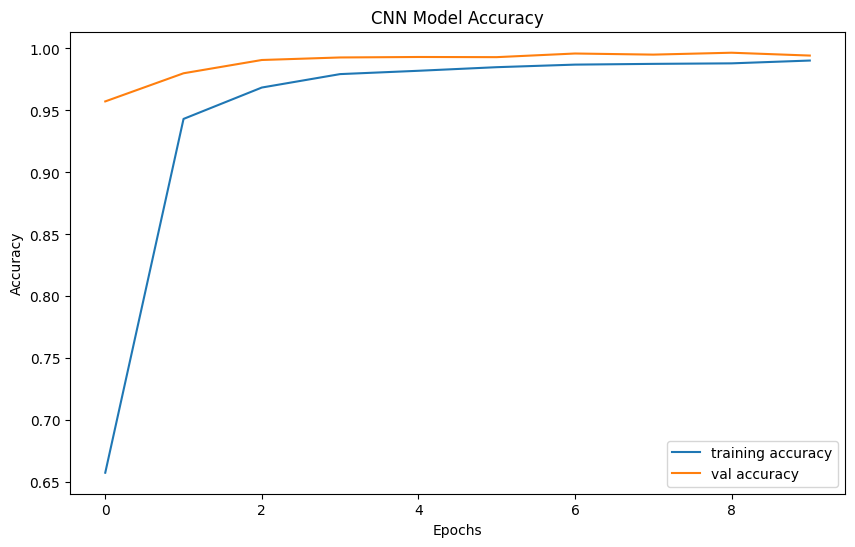

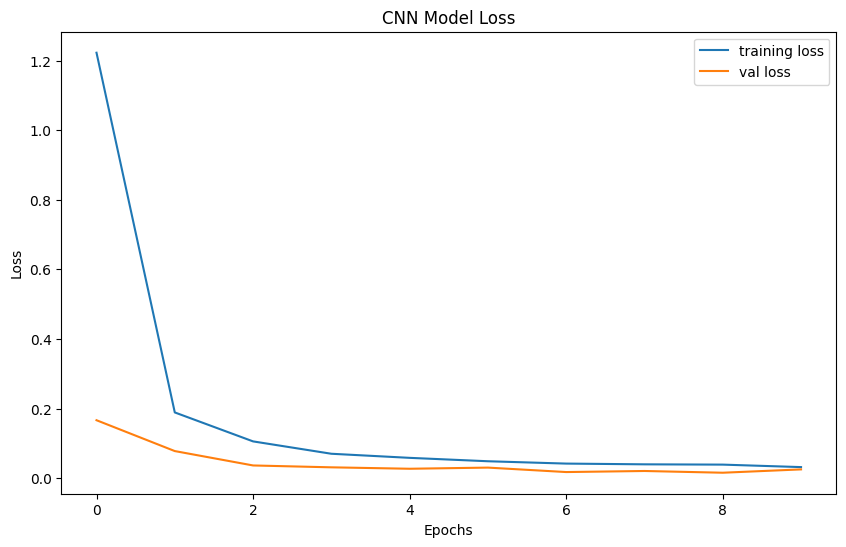

In [13]:
#plotting graphs for accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# Evaulating the model

# Evaluate the CNN model with data augmentation
cnn_eval = cnn_model.evaluate(X_t2, y_t2)
print(f'CNN Model Loss: {cnn_eval[0]} | Test Accuracy: {cnn_eval[1]}')

# Evaluate the Transfer Learning model with data augmentation
transfer_eval = tl_model.evaluate(X_t2, y_t2)
print(f'Transfer Learning Loss: {transfer_eval[0]} | Test Accuracy: {transfer_eval[1]}')


246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9962 - loss: 0.0182
CNN Model Loss: 0.018780164420604706 | Test Accuracy: 0.9956643581390381
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.9857 - loss: 0.0432
Transfer Learning Loss: 0.03959358111023903 | Test Accuracy: 0.9878857731819153


395/395 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step
0.956215360253365
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.94      0.99      0.97       720
           2       0.96      0.98      0.97       750
           3       0.95      0.96      0.95       450
           4       0.99      0.98      0.98       660
           5       0.97      0.92      0.94       630
           6       1.00      0.88      0.94       150
           7       1.00      0.89      0.94       450
           8       0.99      0.91      0.95       450
           9       0.94      0.99      0.97       480
          10       0.99      0.98      0.99       660
          11       0.86      0.99      0.92       420
          12       0.97      0.97      0.97       690
          13       0.99      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.81      0.99      0.89       210
          16       0

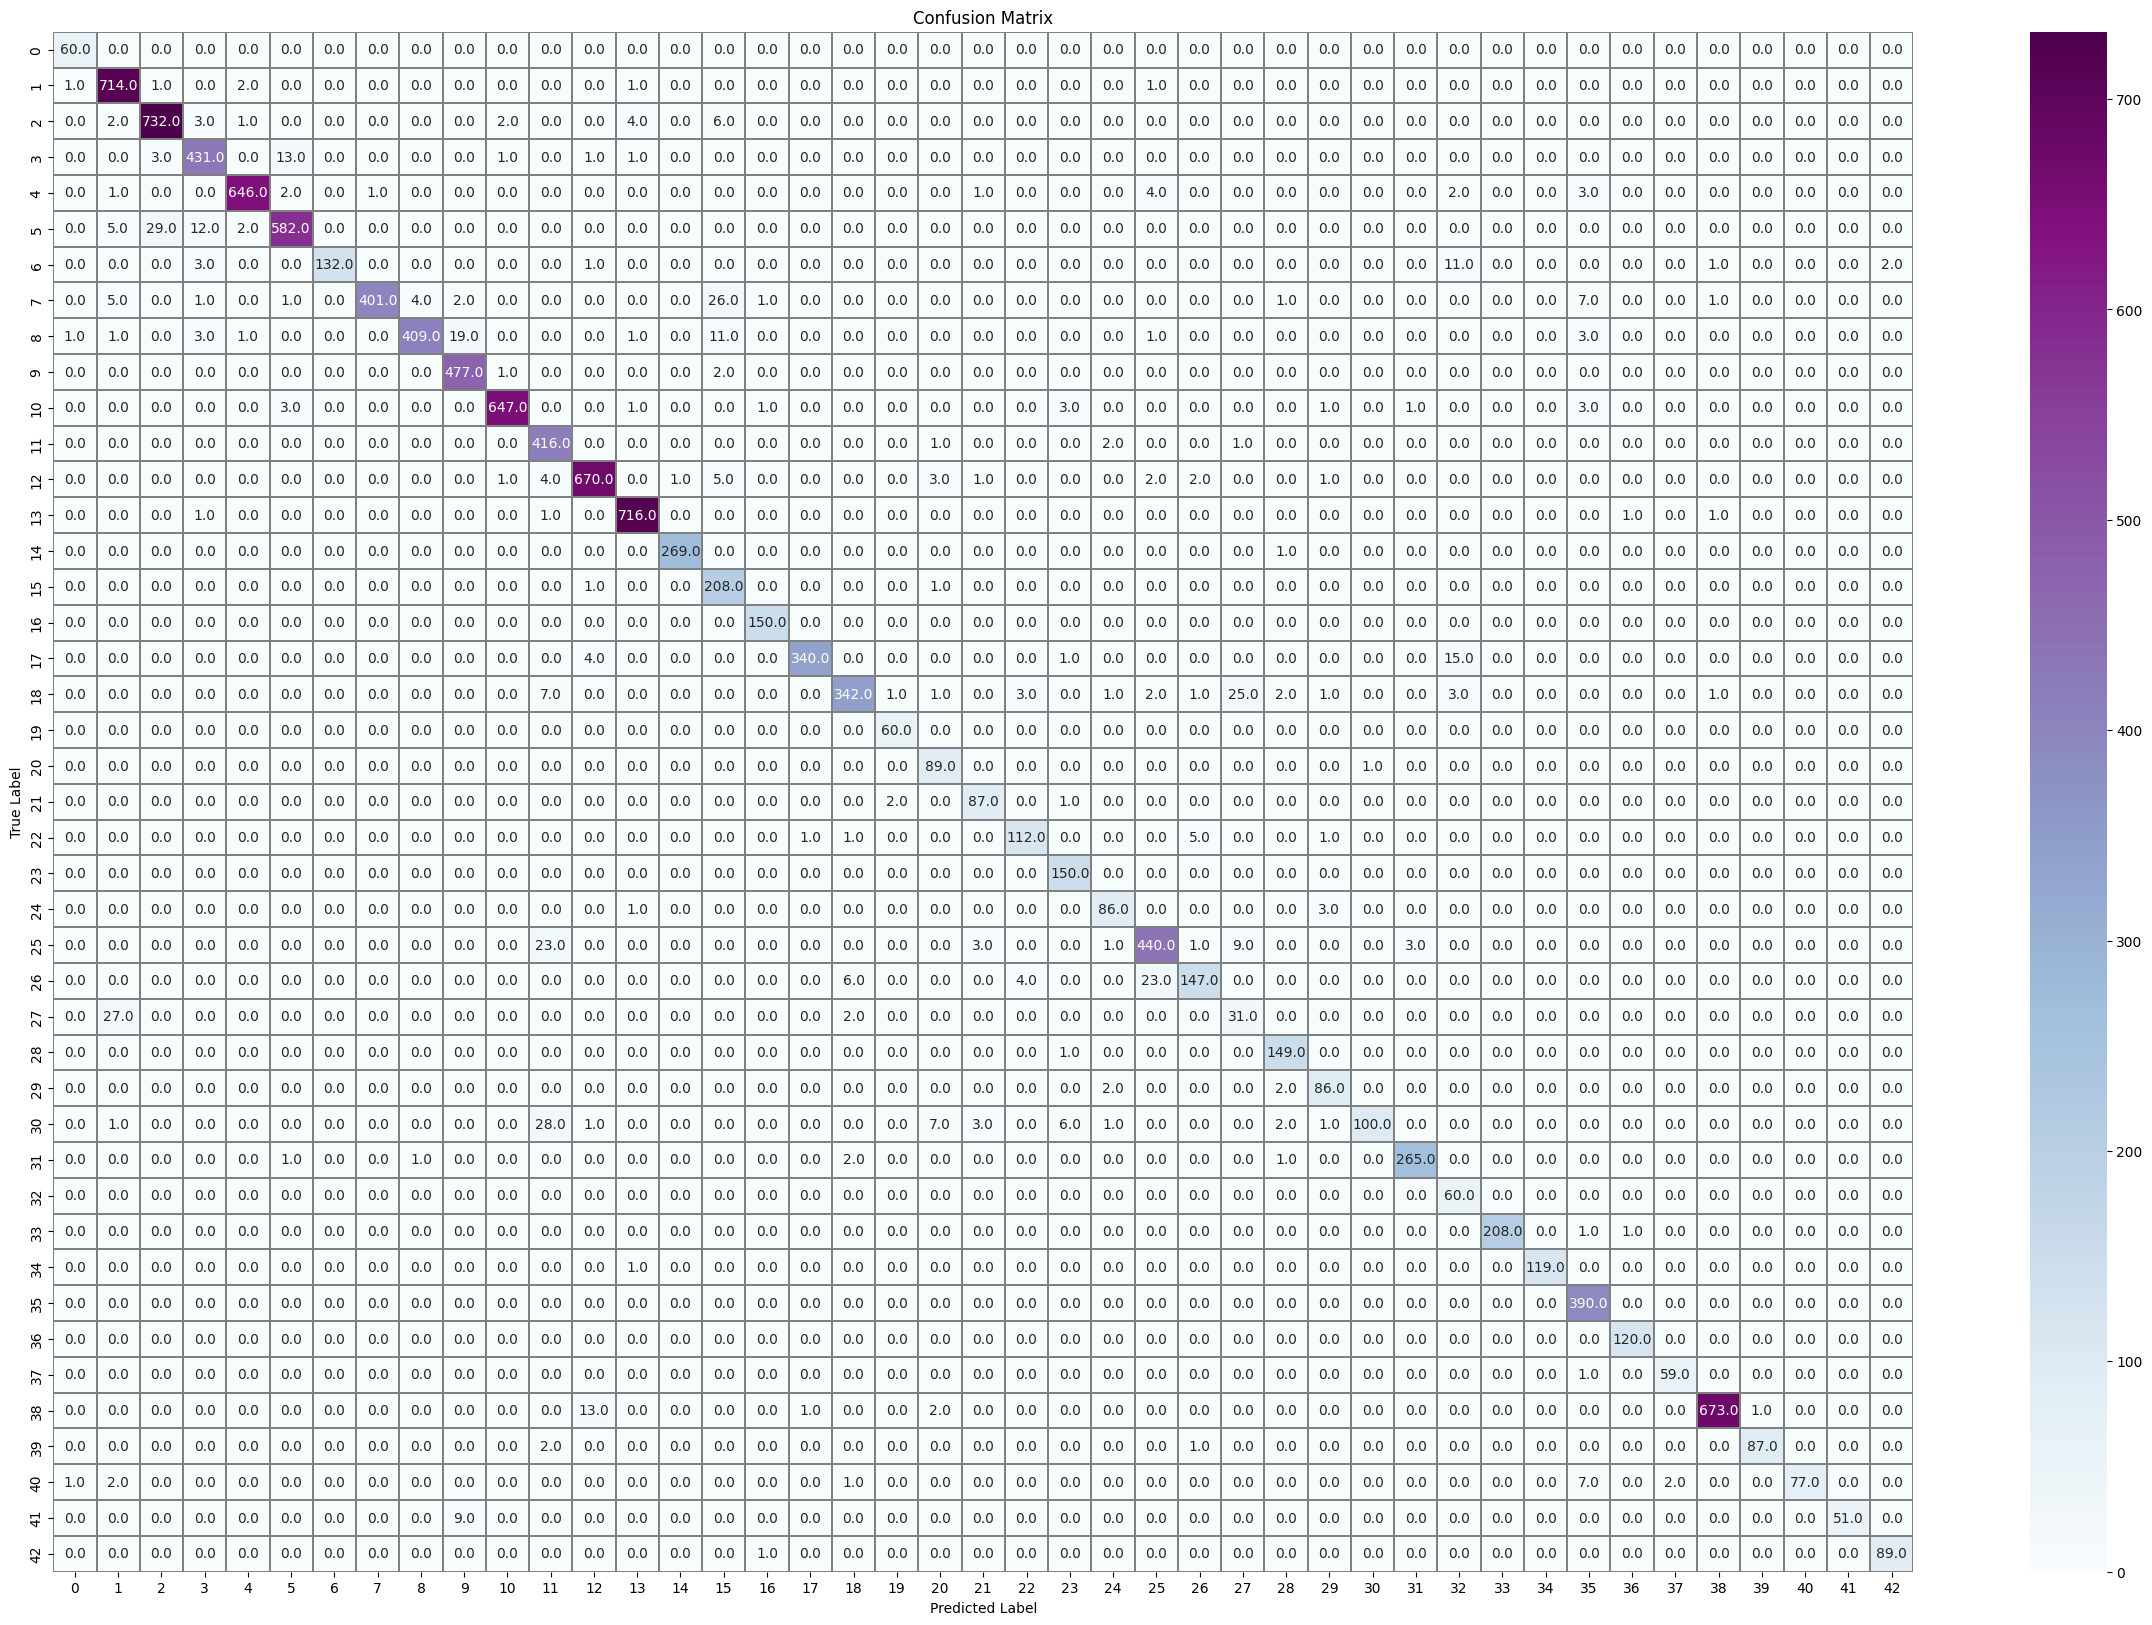

In [28]:
# Model Testing
#testing accuracy on test dataset
dataset_base_path = '/content/drive/MyDrive/Colab Notebooks/Dataset'
#dataset_base_path = '/content/GTSRB'

y_test = pd.read_csv(os.path.join(dataset_base_path, 'Test.csv'))
labels = y_test["ClassId"].values
imgs = y_test["Path"].values
data=[]


for img in imgs:
   full_img_path = os.path.join(dataset_base_path, img)
   image = Image.open(full_img_path)
   #print(full_img_path)
   image = image.resize((32,32))
   data.append(np.array(image))
X_test=np.array(data)

# Classification Report
pred = np.argmax(cnn_model.predict(X_test), axis=-1)

# Accuracy with the test data
print(accuracy_score(labels, pred))
print(classification_report(labels, pred))

# Confusion Matrix
cm = confusion_matrix(labels, pred)
f,ax = plt.subplots(figsize=(30, 20))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt=".1f", ax=ax);
plt.xlabel("Predicted Label");
plt.ylabel("True Label");
plt.title("Confusion Matrix");
plt.show();

cnn_model.save('Traffic_Sign_Classifier.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')